In [1]:
import numpy as np 

import sys
import os
#import matplotlib
#matplotlib.use('Agg')
import pylab as plt 
sys.path.append('/global/u1/j/jelvinpo/DES/lss_sys/')
import lsssys
import twopoint
import fitsio as fio
import healpy as hp 


Reading config file
Working with Y3
failed to import mpi4py - mpi methods won't work
skymapper not found, some visualisation tools won't work
seaborn required for sp_corrmatrix. plot_matrix method will not work


In [2]:
#paths and config

mock_dir = '/global/project/projectdirs/des/monroy/systematics_analysis/enet_weights_tests/contaminated_lognormal_mocks_enet_weights/'
mock_file_temp = mock_dir + 'y3_redmagic_v0.5.1_newzbinning_contaminated_2.0sig_nside512_mock{imock}.fits.gz'

f_map_dir = '/global/project/projectdirs/des/nweaverd/y3_enet/systematics_analysis/output/fracdet_thresh_0d1_sqrt_pca/mocks_enet_std_107_contaminated/fest_maps/'
f_map_temp = f_map_dir+'{label}_Fest_map_Nbase108_512_izbin{ibin}_minfrac0.1_mock{imock}_sqrt_pca.fits.gz'

extra_label = 'enetmocks'

outfile_temp = 'wtheta_redmagic_y3_mock{imock}_bs{bin_slop}_{label}_{extra_label}.fits'

#labels = ['noweights','enet','enet2','enet_kptpl']
#labels = ['nosys', 'noweights','enet','enet2','enet_kptpl']
#labels = ['nosys']
labels = ['enet']

nthetabins = 20
thetamax = 250./60.
thetamin = 2.5/60.
bin_slop = 0.05
num_threads = 10

angle_edges = np.logspace(np.log10(thetamin*60.),np.log10(thetamin*60.), 21)


In [3]:
def load_galmap_w(ibin, imock, label):
    if label == 'nosys':
        mock = lsssys.Mock(None, 512, empty=True )
        mock.load( mock_nosys_file_temp.format(imock=imock), loadfracdet=True)
    else:
        mock = lsssys.Mock(None, 512, empty=True )
        mock.load( mock_file_temp.format(imock=imock), loadfracdet=True)
    
    galmap_w = mock.ngal[ibin]
    
    if label != 'noweights' and label != 'nosys' :
        f = lsssys.SysMap(f_map_temp.format(label=label, ibin=ibin, imock=imock) )
        assert (f.data[~galmap_w.mask] == hp.UNSEEN).any() == False
        galmap_w.data[~galmap_w.mask] = galmap_w.data[~galmap_w.mask]/(1. + f.data[~galmap_w.mask]) 
    return galmap_w

In [7]:
%%capture

#compute clustering
nbins = 5
nmocks = 100

for label in labels:
    for imock in range(nmocks):
        
        outfile = outfile_temp.format(
            bin_slop = bin_slop,
            label=label, 
            imock=imock,
            extra_label=extra_label,
        )
        
        #if os.path.exists(outfile):
        #    continue
        
        w_dict = {}
        for ibin in range(nbins):
            try:
                galmap_w = load_galmap_w(ibin, imock, label)
            except IOError:
                print('couldnt find', imock, ibin)
                continue
            
            theta, wtheta = lsssys.corr2pt(galmap_w, galmap_w, 
              nthetabins, thetamax, thetamin, 
              bin_slop=bin_slop, num_threads=num_threads, bin_type=None, 
              delta_input=False, w1=None, w2=None, 
              scale1=1./galmap_w.fracdet, scale2=1./galmap_w.fracdet, 
              return_var=False, 
              returncorr=False, jointmask=None, 
              fracweights=True, fracweights2=True, 
              weights=None, weights2=None)
            w_dict['theta_{0}_{0}'.format(ibin)] = theta
            w_dict[ibin,ibin] = wtheta
            np.savetxt('theta_bin{0}_mock{1}_{2}.txt'.format(ibin,imock,label),theta)
            np.savetxt('wtheta_bin{0}_mock{1}_{2}.txt'.format(ibin,imock,label),theta)

        try:
            w_dict['angle_min'] = angle_edges[:-1]
            w_dict['angle_max'] = angle_edges[1:]

            spectrum = lsssys.corrdict_2_spectrumtype(w_dict, autoonly=True, name='wtheta', 
                        kernel1='nz_lens', kernel2='nz_lens',)

            tp = twopoint.TwoPointFile([spectrum], kernels=None, windows={}, covmat_info=None)
            tp.to_fits(outfile, overwrite=True)
        except KeyError:
            print('key error')
            continue
        
            

In [8]:
nmocks = 100

labels = ['noweights', 'enet', 'enet2', 'enet_kptpl']
colors = {
    'noweights':  'c',
    'y3 fiducial':'k',
    'enet':       'r',
    'enet2':      'b',
    'enet_kptpl': 'y',
}

min_angle = 2.*hp.nside2resol(512, arcmin=True )

w_dict = {}
for label in labels:
    for ibin in range(5):
        dvecs = []
        for imock in range(nmocks):
            outfile = outfile_temp.format(
                bin_slop = bin_slop,
                label=label, 
                imock=imock)
            spec = twopoint.TwoPointFile.from_fits(outfile,covmat_name=None).get_spectrum('wtheta')
            
            select = (spec.bin1==ibin+1)*(spec.bin2==ibin+1)*(spec.angle > min_angle)
            theta = spec.angle[select]
            w = spec.value[select]
            dvecs.append(w)
        dvecs = np.array(dvecs)
        wmean = np.average(dvecs,axis=0)
        
        w_dict[label,ibin] = theta, wmean, dvecs
        

KeyError: 'extra_label'

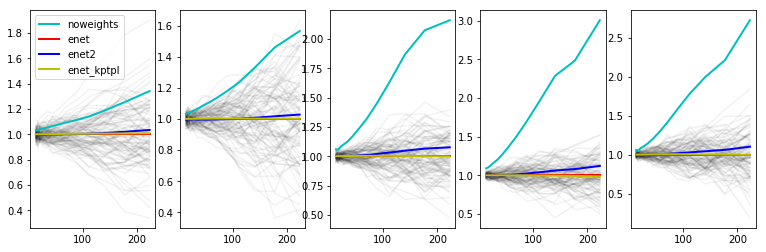

In [18]:
fig, axs = plt.subplots(1,5, figsize=(13,4))

for ibin in range(5):
    theta, wmean, dvecs = w_dict['enet',ibin]
    for dvec in dvecs:
        axs[ibin].plot(theta, dvec/wmean, color='k', alpha=0.05)

for ibin in range(5):
    theta0, wmean0, dvecs0 = w_dict['enet',ibin]
    for label in labels:
        theta, wmean, dvecs = w_dict[label,ibin]
        
        if ibin == 0:
            label0 = label
        else:
            label0 = None

        axs[ibin].plot(theta, wmean/wmean0, color=colors[label], lw=2.0, label=label0)

axs[0].legend()
    